# Lab 5: Spam Detection

**Deadline**: Thursday, July 9, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Baiwu (Chris) Zhang  

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1wQ8BX-i3khRJViR4w2qwxgJcBDl4AsqE?usp=sharing

In [ ]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
print("LABEL FOR A SPAM MESSAGE IS SPAM. BELOW IS AN EXAMPLE OF A SPAM SMS")
print(next(line for line in open('/content/drive/My Drive/APS 360/Labs/Lab 5/SMSSpamCollection') if line.split()[0] == "spam"))
print("LABEL FOR A NON-SPAM MESSAGE IS HAM. BELOW IS AN EXAMPLE OF A NON-SPAM SMS")
print(next(line for line in open('/content/drive/My Drive/APS 360/Labs/Lab 5/SMSSpamCollection') if line.split()[0] == "ham"))

LABEL FOR A SPAM MESSAGE IS SPAM. BELOW IS AN EXAMPLE OF A SPAM SMS
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

LABEL FOR A NON-SPAM MESSAGE IS HAM. BELOW IS AN EXAMPLE OF A NON-SPAM SMS
ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
num_spam = sum([line.split()[0] == "spam" for line in open('/content/drive/My Drive/APS 360/Labs/Lab 5/SMSSpamCollection')])
num_ham = sum([line.split()[0] == "ham" for line in open('/content/drive/My Drive/APS 360/Labs/Lab 5/SMSSpamCollection')])
print("There are %s spam messages in the dataset" %num_spam)
print("There are %s non-spam messages in the dataset" %num_ham)

There are 747 spam messages in the dataset
There are 4827 non-spam messages in the dataset


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**Advantages**


1.   Storing word embeddings require more memory. A character level RNN only requires embeddings for the alphabet with accentation and capitalization, along with a handful of special characters found in written text. On the other hand, there are thousands of words, each of which would need its own embedding.

2.   Mispelled words or words not present in the embeddings database will not generate a usable token. This may suffice for certain applications but it greatly restricts the flexability of our model. In the particular case of SMS text messages, many people abbreviate words using single characters
(e.g. are -> r, you -> u, what about you -> wbu). Therefore, using character embeddings is essential to the feasibility of the model.


**Disadvantages**


1.   Given sentences with proper spelling, character level RNNs will perform worse at capturing long-distance relationships between words because it analyzes semantics one character at a time.
2.   Character level RNNs are harder and take longer to train. The number of elements in a sequence is larger when using a character-level model as opposed to a word-level model; these elements are respectively characters or words. Since a character-level model requires more complexity, it has a longer error propogation path, making it susceptible to vanishing/exploding gradients.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("/content/drive/My Drive/APS 360/Labs/Lab 5/SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
# train, valid, test = ...

train, valid, test = dataset.split([.6, .2, .2], random_state=random.getstate())

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi -> A dictionary mapping token strings to numerical identifiers
#text_field.vocab.itos -> A list of token strings indexed by their numerical identifiers

In [ ]:
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<function _default_unk_index at 0x7feb1ac629d8>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, '0': 13, 'h': 14, 'd': 15, 'c': 16, '.': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, '8': 27, 'T': 28, 'k': 29, 'v': 30, 'E': 31, '5': 32, 'S': 33, 'C': 34, 'O': 35, 'I': 36, 'N': 37, 'x': 38, '4': 39, '7': 40, 'A': 41, '6': 42, '3': 43, 'R': 44, '!': 45, ',': 46, '9': 47, 'P': 48, 'W': 49, 'M': 50, 'L': 51, 'U': 52, 'H': 53, 'D': 54, 'B': 55, 'F': 56, 'G': 57, 'Y': 58, "'": 59, '/': 60, '£': 61, '?': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, '*': 69, 'K': 70, 'j': 71, 'J': 72, ')': 73, ';': 74, '+': 75, 'q': 76, '(': 77, 'Q': 78, '"': 79, '#': 80, '@': 81, '=': 82, '>': 83, 'Z': 84, 'ü': 85, '$': 86, '_': 87, '|': 88, 'Ü': 89, '<': 90, '[': 91, ']': 92, '\x92': 93, '%': 94, '‘': 95, '¡': 96, '“': 97, '…': 98, '\x93': 99, 'ú': 100, '–': 101, '\\': 102, '~'

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

The token 'unk' is used to represent an unknown character. This token can be used if a character in a SMS message is not present in the vocabulary.

The token 'pad' is filler used to pad sequences so all sequences in a batch are the same length.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
for i, batch in zip(range(10), train_iter):
    
    size = batch.sms[0].shape[1] # compute sequence length after padding

    largest = 0 # store largest unpadded sequence length
    num = 0 # store how many <pad> tokens are used

    # determine values for 'largest' and 'num'
    for seq in batch.sms[0]:
      arr = seq.numpy() # convert to numpy array to use np.where()
      seq_len = np.where(arr == 1)[0] # find index of padding tokens
      
      if seq_len.size > 0: # padding is used
        num += seq_len.size # determine how many <pad> tokens are in this sequence
        seq_len = seq_len[0] # first instance of padding
      else: # no padding used
        seq_len = size

      largest = max(largest, seq_len) # update variable holding largest unpadded sequence length

    # print batch information
    print("BATCH %d" %i)
    print("\tPADDED LENGTH: %d" %size)
    print("\tLARGEST UNPADDED SEQUENCE LENGTH: %d" %largest)
    print("\t<pad> TOKENS USED: %d" %num)
    print()

BATCH 0
	PADDED LENGTH: 49
	LARGEST UNPADDED SEQUENCE LENGTH: 49
	<pad> TOKENS USED: 44

BATCH 1
	PADDED LENGTH: 148
	LARGEST UNPADDED SEQUENCE LENGTH: 148
	<pad> TOKENS USED: 20

BATCH 2
	PADDED LENGTH: 160
	LARGEST UNPADDED SEQUENCE LENGTH: 160
	<pad> TOKENS USED: 0

BATCH 3
	PADDED LENGTH: 95
	LARGEST UNPADDED SEQUENCE LENGTH: 95
	<pad> TOKENS USED: 73

BATCH 4
	PADDED LENGTH: 159
	LARGEST UNPADDED SEQUENCE LENGTH: 159
	<pad> TOKENS USED: 0

BATCH 5
	PADDED LENGTH: 118
	LARGEST UNPADDED SEQUENCE LENGTH: 118
	<pad> TOKENS USED: 71

BATCH 6
	PADDED LENGTH: 127
	LARGEST UNPADDED SEQUENCE LENGTH: 127
	<pad> TOKENS USED: 35

BATCH 7
	PADDED LENGTH: 105
	LARGEST UNPADDED SEQUENCE LENGTH: 105
	<pad> TOKENS USED: 53

BATCH 8
	PADDED LENGTH: 114
	LARGEST UNPADDED SEQUENCE LENGTH: 114
	<pad> TOKENS USED: 15

BATCH 9
	PADDED LENGTH: 42
	LARGEST UNPADDED SEQUENCE LENGTH: 42
	<pad> TOKENS USED: 15



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
# RNN Architecture
class SpamRNN(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN, self).__init__()
    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.ident[x]
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    output = self.fc(torch.max(out, dim=1)[0])
    return output

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def evaluate(model, data, criterion, batch_size):
    """ Compute the accuracy and loss of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> evaluate(model, valid, criterion, batch_size) # the variable `valid` is from above
    """

    data_iter = torchtext.data.BucketIterator(data,
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.sms), # to minimize padding
                              sort_within_batch=True, # sort within each batch
                              repeat=False) # repeat the iterator for many epochs
    correct, total, losses, i = 0.0, 0.0, 0.0, 0.0
    for batch in data_iter:
      input = batch.sms[0]
      if use_cuda and torch.cuda.is_available():
              input = input.cuda()
      output = model(input)
      loss = criterion(output, batch.label)
      losses += loss.item()
      i += 1
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(batch.label.view_as(pred)).sum().item()
      total += batch.sms[1].shape[0]
    return correct / total, losses / (i + 1)

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
def train_rnn_network(model, train, valid, batch_size=32, num_epochs=30, learning_rate=1e-5):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_acc, train_loss, val_acc, val_loss = [], [], [], []
  epochs = []

  train_loader = torchtext.data.BucketIterator(train,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs

  valid_loader = torchtext.data.BucketIterator(valid,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs

  print("COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS")

  for epoch in range(num_epochs):
    for batch in train_loader:
      optimizer.zero_grad()
      input = batch.sms[0]
      if use_cuda and torch.cuda.is_available():
              input = input.cuda()
      pred = model(input)
      loss = criterion(pred, batch.label)
      loss.backward()
      optimizer.step()

    epochs.append(epoch)

    tmp_acc, tmp_loss = evaluate(model, train, criterion, batch_size)
    train_acc.append(tmp_acc)
    train_loss.append(tmp_loss)

    tmp_acc, tmp_loss = evaluate(model, valid, criterion, batch_size)
    val_acc.append(tmp_acc)
    val_loss.append(tmp_loss)

    print("%d \t\t %10.9f \t\t %10.7f \t\t %10.9f \t\t %10.7f" % (epochs[-1], train_acc[-1], train_loss[-1], val_acc[-1], val_loss[-1]))

  # plotting
  plt.title("Model Loss")
  plt.plot(epochs, train_loss, label="Train")
  plt.plot(epochs, val_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.xticks(np.arange(min(epochs), max(epochs)+1, 1.0))
  plt.show()
  print("Final Training Loss: {}".format(train_loss[-1]))
  print("Final Validation Loss: {}".format(val_loss[-1]))

  plt.title("Model Accuracy")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, val_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.xticks(np.arange(min(epochs), max(epochs)+1, 1.0))
  plt.show()
  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
# toggle cuda
use_cuda = False # session kept crashing when using cuda

# set random seed
torch.manual_seed(1000)

COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
0 		 0.534376561 		  0.6814276 		 0.164125561 		  0.6887544
1 		 0.574496421 		  0.6726859 		 0.223318386 		  0.6837830
2 		 0.631929416 		  0.6604204 		 0.318385650 		  0.6785867
3 		 0.774263359 		  0.6423448 		 0.578475336 		  0.6643298
4 		 0.864324954 		  0.6153965 		 0.747085202 		  0.6470359
5 		 0.924754453 		  0.5765600 		 0.909417040 		  0.6033731
6 		 0.930414516 		  0.5221101 		 0.918385650 		  0.5602436
7 		 0.928083902 		  0.4525227 		 0.930941704 		  0.4901459
8 		 0.930248044 		  0.3721480 		 0.943497758 		  0.4084279
9 		 0.935908107 		  0.3027216 		 0.949775785 		  0.3318259
10 		 0.937073414 		  0.2524191 		 0.958744395 		  0.2660141
11 		 0.946562344 		  0.2195919 		 0.949775785 		  0.2587503
12 		 0.953387714 		  0.1908133 		 0.956053812 		  0.2232710
13 		 0.945729982 		  0.1744396 		 0.970403587 		  0.1701939
14 		 0.961544864 		  0.1522958 		 0.952466368 		  0.1899185
15 		 0.

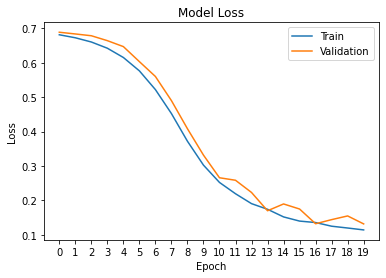

Final Training Loss: 0.11449215244797487
Final Validation Loss: 0.13194710854440928


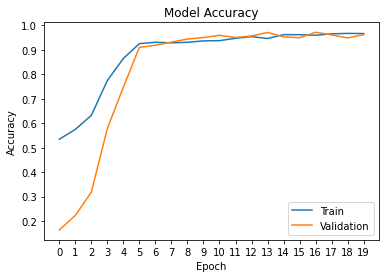

Final Training Accuracy: 0.965873147994007
Final Validation Accuracy: 0.9614349775784753


In [ ]:
# Baseline
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
if use_cuda and torch.cuda.is_available():
    model_1 = model_1.cuda()
    print("CUDA Available! Using GPU...")

train_rnn_network(model_1, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

**OPTIMIZING OUTPUT POOLING BEFORE PASSING INTO CLASSIFICATION NETWORK**

The baseline uses max-pooling.

I will compare it to a model that doesn't use pooling and one that contactonates max-pooling and average-pooling.

I expect the model with no pooling to perform worse than the base case while the concatenation should perform better. 

In [ ]:
class SpamRNN_no_pool(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN_no_pool, self).__init__()
    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.ident[x]
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output to the classifier
    output = self.fc(out[:, -1, :])
    return output

COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
0 		 0.544864325 		  0.6853630 		 0.833183857 		  0.6402769
1 		 0.664558016 		  0.6734975 		 0.773094170 		  0.6555929
2 		 0.733810554 		  0.6521357 		 0.694170404 		  0.6586626
3 		 0.767105044 		  0.5945715 		 0.748878924 		  0.6113470
4 		 0.877809223 		  0.3391344 		 0.929147982 		  0.2663458
5 		 0.897619444 		  0.2977480 		 0.924663677 		  0.2504572
6 		 0.914766106 		  0.2623129 		 0.911210762 		  0.2671409
7 		 0.921425004 		  0.2447457 		 0.909417040 		  0.2577226
8 		 0.924421508 		  0.2326181 		 0.913901345 		  0.2499952
9 		 0.929582154 		  0.2217058 		 0.926457399 		  0.2131915
10 		 0.925586815 		  0.2183573 		 0.896860987 		  0.2750808
11 		 0.935575162 		  0.2015272 		 0.912107623 		  0.2457865
12 		 0.934576328 		  0.2001273 		 0.909417040 		  0.2457885
13 		 0.943399367 		  0.1883542 		 0.923766816 		  0.2146617
14 		 0.944564675 		  0.1827636 		 0.932735426 		  0.1932963
15 		 0.

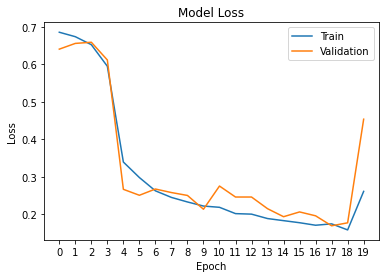

Final Training Loss: 0.2608431437639175
Final Validation Loss: 0.45336125211583245


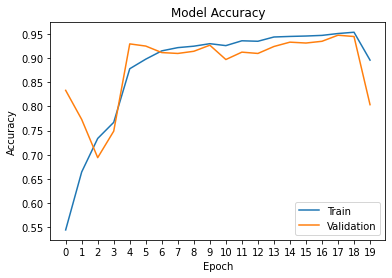

Final Training Accuracy: 0.8956217745963043
Final Validation Accuracy: 0.8035874439461883


In [ ]:
model_2 = SpamRNN_no_pool(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_2, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4)

In [ ]:
class SpamRNN_concat(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN_concat, self).__init__()
    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size*2, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.ident[x]
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Concatenate the max-pooling and average-pooling
    out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
    # Pass the output to the classifier
    output = self.fc(out)
    return output

COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
0 		 0.517396371 		  0.6777310 		 0.134529148 		  0.7252687
1 		 0.531879474 		  0.6638851 		 0.150672646 		  0.6992546
2 		 0.658398535 		  0.6329720 		 0.355156951 		  0.6755366
3 		 0.912269019 		  0.5716742 		 0.855605381 		  0.6208611
4 		 0.928416847 		  0.4807506 		 0.939910314 		  0.5298687
5 		 0.931912768 		  0.3829719 		 0.956053812 		  0.4108256
6 		 0.931246879 		  0.3050754 		 0.951569507 		  0.3336180
7 		 0.931413351 		  0.2511475 		 0.953363229 		  0.2615144
8 		 0.941068753 		  0.2137714 		 0.950672646 		  0.2282053
9 		 0.942400533 		  0.1874351 		 0.956950673 		  0.1909259
10 		 0.948726486 		  0.1666533 		 0.956053812 		  0.1735869
11 		 0.953554187 		  0.1528076 		 0.944394619 		  0.1847199
12 		 0.955551856 		  0.1403795 		 0.944394619 		  0.1724613
13 		 0.958548360 		  0.1296319 		 0.946188341 		  0.1600626
14 		 0.957216581 		  0.1199641 		 0.958744395 		  0.1310440
15 		 0.

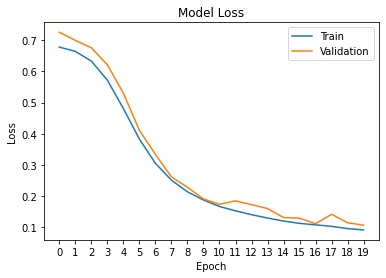

Final Training Loss: 0.09156640408136857
Final Validation Loss: 0.10674269404262304


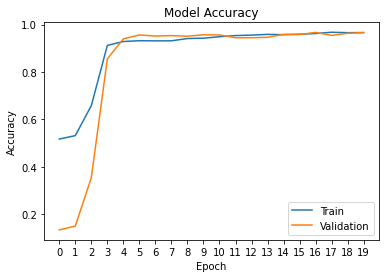

Final Training Accuracy: 0.9662060928916264
Final Validation Accuracy: 0.9659192825112107


In [ ]:
model_3 = SpamRNN_concat(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_3, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4)

As expected, no pooling was worse. The loss and accuracy were respectively higher and lower. Furthermore, the model was unstable as the curves had drastic fluctuations throughout the trainng process.

Concatenating the max and average pooling lead to higher accuracy and lower loss for both the training and validation datasets. The curves also look slightly smoother.

**OPTIMIZING TYPE OF RNN**

The baseline uses nn.RNN().

I will compare it to models that use nn.GRU() and nn.LSTM() respectively.

I expect the model using nn.LSTM() to perform the best because the added complexity allows the network to tune itself with more controlability.

In [ ]:
class SpamRNN_gru(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN_gru, self).__init__()
    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.GRU(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.ident[x]
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    output = self.fc(torch.max(out, dim=1)[0])
    return output

COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
0 		 0.482603629 		  0.6936899 		 0.865470852 		  0.5908288
1 		 0.482603629 		  0.6800746 		 0.865470852 		  0.6175044
2 		 0.814716164 		  0.6662001 		 0.932735426 		  0.6356731
3 		 0.940236391 		  0.6486101 		 0.936322870 		  0.6423841
4 		 0.914100216 		  0.6223832 		 0.879820628 		  0.6407835
5 		 0.947061761 		  0.5779112 		 0.929147982 		  0.6027507
6 		 0.942899950 		  0.4863577 		 0.929147982 		  0.5451495
7 		 0.938571666 		  0.3830363 		 0.934529148 		  0.4683071
8 		 0.937739304 		  0.3308871 		 0.936322870 		  0.4097849
9 		 0.936074580 		  0.2975132 		 0.939013453 		  0.3603095
10 		 0.934576328 		  0.2718887 		 0.939910314 		  0.3142361
11 		 0.949225903 		  0.2505689 		 0.924663677 		  0.3401661
12 		 0.951722990 		  0.2243065 		 0.932735426 		  0.2935166
13 		 0.955385384 		  0.2045953 		 0.931838565 		  0.2611907
14 		 0.959380722 		  0.1875472 		 0.925560538 		  0.2551278
15 		 0.

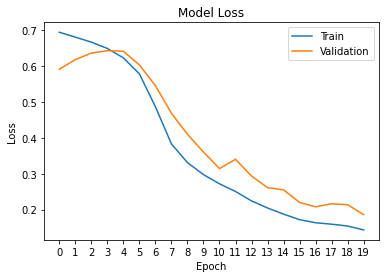

Final Training Loss: 0.14358723139952098
Final Validation Loss: 0.1861457038256857


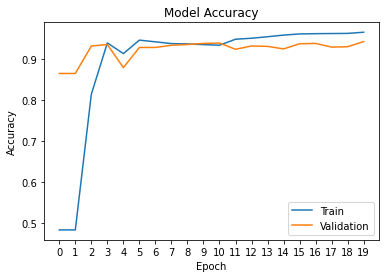

Final Training Accuracy: 0.9663725653404361
Final Validation Accuracy: 0.9434977578475336


In [ ]:
model_4 = SpamRNN_gru(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_4, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4)

In [ ]:
class SpamRNN_lstm(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN_lstm, self).__init__()
    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.LSTM(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.ident[x]
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
    c0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, (h0, c0))
    # Pass the output of the last time step to the classifier
    output = self.fc(torch.max(out, dim=1)[0])
    return output

COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
0 		 0.482603629 		  0.6918005 		 0.865470852 		  0.6371962
1 		 0.482603629 		  0.6882185 		 0.865470852 		  0.6447002
2 		 0.754453138 		  0.6775061 		 0.950672646 		  0.6527741
3 		 0.847844182 		  0.5860062 		 0.690582960 		  0.6490689
4 		 0.939570501 		  0.4778243 		 0.926457399 		  0.6070616
5 		 0.936906942 		  0.4339705 		 0.947982063 		  0.5630615
6 		 0.942899950 		  0.3907923 		 0.930941704 		  0.5380495
7 		 0.945397037 		  0.3478285 		 0.943497758 		  0.4438816
8 		 0.946395871 		  0.3163159 		 0.944394619 		  0.3928519
9 		 0.933743965 		  0.3058331 		 0.959641256 		  0.3311446
10 		 0.946728816 		  0.2779166 		 0.945291480 		  0.3271922
11 		 0.943565840 		  0.2674528 		 0.953363229 		  0.3015630
12 		 0.943898785 		  0.2602211 		 0.930941704 		  0.3326334
13 		 0.948892958 		  0.2401247 		 0.942600897 		  0.2940690
14 		 0.913767272 		  0.2764317 		 0.964125561 		  0.2390544
15 		 0.

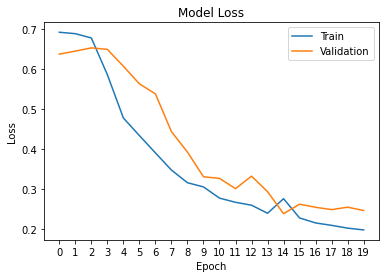

Final Training Loss: 0.19853303530228833
Final Validation Loss: 0.24693122237092918


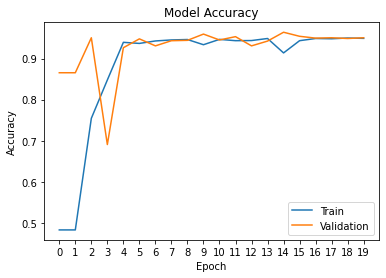

Final Training Accuracy: 0.9492259031130348
Final Validation Accuracy: 0.9506726457399103


In [ ]:
model_5 = SpamRNN_lstm(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_5, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4)

Both the GRU and LSTM models performed worse than the baseline. Tle loss and accuracy suffered from switching architectures. Furthermore, the shape of the curves are irregular. This is unexpected and despite multiple runs, I saw the same results.

**OPTIMIZING BATCH SIZE**

The baseline uses a batch size of 32.

I will compare it to models that have a batch size of 16 and 64 respectively.

I expect that increasing/decreasing the batch size will respectively weaken/strengthen model performance because the number of padding tokens used will increase/decrease.

COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
0 		 0.626269352 		  0.6771174 		 0.344394619 		  0.6924577
1 		 0.705676711 		  0.6533869 		 0.465470852 		  0.6805215
2 		 0.857166639 		  0.6177509 		 0.749775785 		  0.6497507
3 		 0.925420343 		  0.5536267 		 0.927354260 		  0.5839199
4 		 0.922257366 		  0.4537286 		 0.960538117 		  0.4718340
5 		 0.931413351 		  0.3598983 		 0.965022422 		  0.3753760
6 		 0.934409855 		  0.2902206 		 0.966816143 		  0.2911567
7 		 0.939570501 		  0.2407170 		 0.963228700 		  0.2375932
8 		 0.946395871 		  0.2040557 		 0.953363229 		  0.2167765
9 		 0.950224738 		  0.1782583 		 0.951569507 		  0.1977219
10 		 0.954220077 		  0.1595826 		 0.947982063 		  0.1853441
11 		 0.954553021 		  0.1447166 		 0.956053812 		  0.1478906
12 		 0.960046612 		  0.1307986 		 0.950672646 		  0.1509103
13 		 0.962543699 		  0.1193274 		 0.953363229 		  0.1452085
14 		 0.965540203 		  0.1090864 		 0.953363229 		  0.1320950
15 		 0.

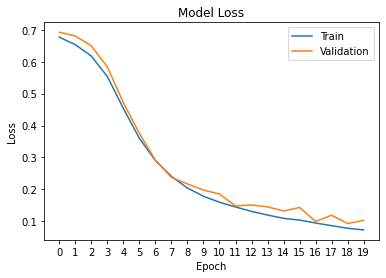

Final Training Loss: 0.0727692712505968
Final Validation Loss: 0.10256514320491066


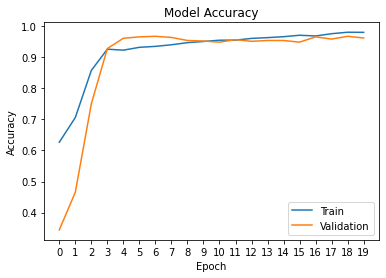

Final Training Accuracy: 0.9795238887964042
Final Validation Accuracy: 0.9614349775784753


In [ ]:
model_6 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_6, train, valid, batch_size=16, num_epochs=20, learning_rate=1e-4)

COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
0 		 0.527384718 		  0.6833746 		 0.164125561 		  0.6765879
1 		 0.524721159 		  0.6798772 		 0.147085202 		  0.6789451
2 		 0.533710671 		  0.6763125 		 0.167713004 		  0.6755463
3 		 0.544031963 		  0.6720332 		 0.183856502 		  0.6729932
4 		 0.569335775 		  0.6668887 		 0.229596413 		  0.6680735
5 		 0.597469619 		  0.6607988 		 0.279820628 		  0.6641803
6 		 0.608123856 		  0.6535326 		 0.297757848 		  0.6625276
7 		 0.636757117 		  0.6446181 		 0.343497758 		  0.6582685
8 		 0.757283170 		  0.6327964 		 0.582062780 		  0.6442190
9 		 0.834526386 		  0.6152932 		 0.707623318 		  0.6316081
10 		 0.916930248 		  0.5836877 		 0.894170404 		  0.6036893
11 		 0.934409855 		  0.5319456 		 0.935426009 		  0.5731361
12 		 0.934243383 		  0.4783065 		 0.969506726 		  0.5079792
13 		 0.934909273 		  0.4288945 		 0.972197309 		  0.4475169
14 		 0.946895289 		  0.3809150 		 0.968609865 		  0.4134889
15 		 0.

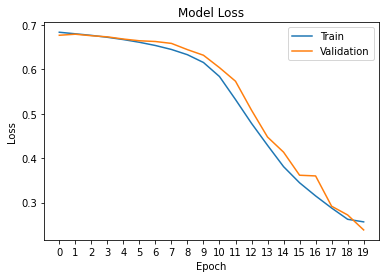

Final Training Loss: 0.25658509323471473
Final Validation Loss: 0.23849709253562124


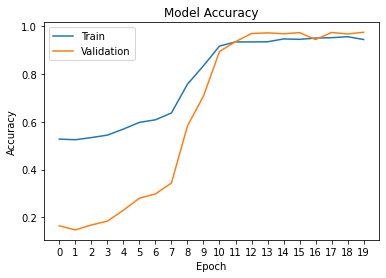

Final Training Accuracy: 0.9443982020975529
Final Validation Accuracy: 0.9748878923766816


In [ ]:
model_7 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_7, train, valid, batch_size=64, num_epochs=20, learning_rate=1e-4)

Increasing the batch size lead to higher loss and improved validation accuracy. 

Decreasing it lead to lower loss, marginally decreased validation accuracy and increased training accuracy.

Therefore, the best model out of the three is the one with a batch size of 16.

**OPTIMIZING LEARNING RATE**

The baseline uses a learning rate of 1e-4.

I will compare it to models that have a learning rate of 1e-3 and 1e-5 respectively.

I expect that increasing the learning rate will allow the model to train better while decreasing it does not improve, or more likely decrease, performance. So far, it seems that the model trains very slowly so changes in loss and accuracy should be more drastic now.

COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
0 		 0.936241052 		  0.3241095 		 0.949775785 		  0.3334123
1 		 0.954719494 		  0.1608530 		 0.937219731 		  0.2027347
2 		 0.965540203 		  0.1203552 		 0.950672646 		  0.1612118
3 		 0.966206093 		  0.1065823 		 0.955156951 		  0.1495440
4 		 0.970034959 		  0.0927215 		 0.963228700 		  0.1150026
5 		 0.972199101 		  0.0845102 		 0.968609865 		  0.1054509
6 		 0.977026802 		  0.0732756 		 0.956950673 		  0.1307350
7 		 0.976527385 		  0.0672936 		 0.965022422 		  0.1081829
8 		 0.964208424 		  0.1018130 		 0.917488789 		  0.2010555
9 		 0.980189779 		  0.0548922 		 0.973991031 		  0.0886952
10 		 0.987348094 		  0.0462087 		 0.965022422 		  0.1044142
11 		 0.987847511 		  0.0409223 		 0.967713004 		  0.0988005
12 		 0.987181621 		  0.0427229 		 0.960538117 		  0.1119168
13 		 0.978358582 		  0.0518350 		 0.972197309 		  0.0885235
14 		 0.989845181 		  0.0367285 		 0.967713004 		  0.0925005
15 		 0.

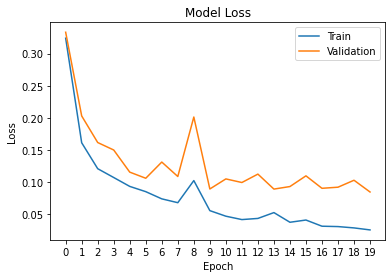

Final Training Loss: 0.024783904065280072
Final Validation Loss: 0.08398700299181251


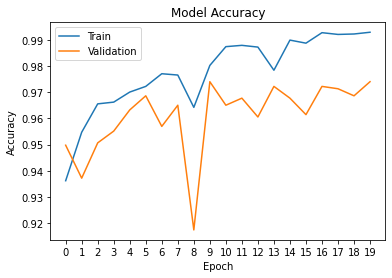

Final Training Accuracy: 0.992841684701182
Final Validation Accuracy: 0.9739910313901345


In [ ]:
model_8 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_8, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-3)

COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
0 		 0.454136840 		  0.6934114 		 0.793721973 		  0.6559505
1 		 0.450640919 		  0.6917134 		 0.768609865 		  0.6580336
2 		 0.476444148 		  0.6901258 		 0.742600897 		  0.6599465
3 		 0.496587315 		  0.6886506 		 0.729147982 		  0.6617470
4 		 0.548360246 		  0.6871781 		 0.681614350 		  0.6643584
5 		 0.579657067 		  0.6859605 		 0.682511211 		  0.6647029
6 		 0.616447478 		  0.6847104 		 0.645739910 		  0.6664339
7 		 0.622440486 		  0.6835135 		 0.612556054 		  0.6679905
8 		 0.642916597 		  0.6823746 		 0.593721973 		  0.6688404
9 		 0.655069086 		  0.6812558 		 0.572197309 		  0.6697269
10 		 0.661395039 		  0.6801778 		 0.562331839 		  0.6703406
11 		 0.678874646 		  0.6790932 		 0.539013453 		  0.6711337
12 		 0.682537040 		  0.6780134 		 0.518385650 		  0.6718992
13 		 0.689695355 		  0.6769647 		 0.502242152 		  0.6723294
14 		 0.692358915 		  0.6758659 		 0.495067265 		  0.6729239
15 		 0.

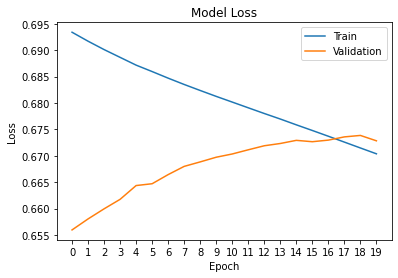

Final Training Loss: 0.670375612993089
Final Validation Loss: 0.6728373451365365


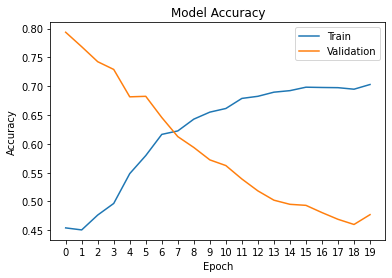

Final Training Accuracy: 0.703013151323456
Final Validation Accuracy: 0.47713004484304933


In [ ]:
model_9 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_9, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-5)

The smaller learning rate destroyed model performance. Loss and accuracy respectively increased/decreased over epochs.

The larger learning rate has generated the most drastic boost to model performance. Loss drastically decreased while accuracy increased.

The best learning rate is therefore 1e-3.

**BEST MODEL**

Putting these observations together, the best model should use a concatenation of max and average pooling, use nn.RNN(), decrease batch size to 16 and increase the learning rate to 1e-3. 

COLUMNS: EPOCH, TRAINING ACCURACY, TRAINING LOSS, VALIDATION ACCURACY, VALIDATION LOSS
0 		 0.949059431 		  0.1670789 		 0.955156951 		  0.1682737
1 		 0.948560013 		  0.1388773 		 0.970403587 		  0.1095539
2 		 0.972532046 		  0.0928064 		 0.968609865 		  0.1167061
3 		 0.977359747 		  0.0800144 		 0.964125561 		  0.1282676
4 		 0.979190944 		  0.0702358 		 0.967713004 		  0.1161170
5 		 0.978358582 		  0.0735117 		 0.962331839 		  0.1393744
6 		 0.979357416 		  0.0693597 		 0.963228700 		  0.1410092
7 		 0.986682204 		  0.0472488 		 0.973094170 		  0.0955345
8 		 0.989678708 		  0.0408968 		 0.972197309 		  0.1015504
9 		 0.991343433 		  0.0366587 		 0.975784753 		  0.0962073
10 		 0.991509905 		  0.0324492 		 0.975784753 		  0.0938161
11 		 0.991509905 		  0.0299803 		 0.973094170 		  0.0995866
12 		 0.991842850 		  0.0344496 		 0.967713004 		  0.1184219
13 		 0.995505244 		  0.0218285 		 0.976681614 		  0.0912486
14 		 0.995671716 		  0.0172370 		 0.978475336 		  0.0924987
15 		 0.

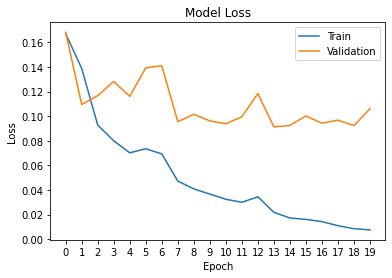

Final Training Loss: 0.007533513285064771
Final Validation Loss: 0.10618913559690708


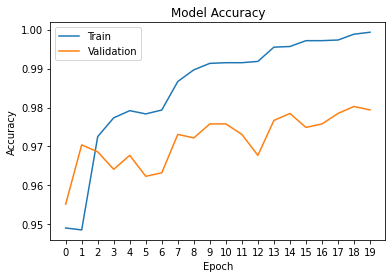

Final Training Accuracy: 0.9993341102047612
Final Validation Accuracy: 0.979372197309417


In [ ]:
model_10 = SpamRNN_concat(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_10, train, valid, batch_size=16, num_epochs=20, learning_rate=1e-3)

This model has the best accuracies and training loss. The validation loss slightly increased to 0.1.

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

false_neg, _ = evaluate(model_10, valid_spam, nn.CrossEntropyLoss(), 16)
false_neg = 1 - false_neg
false_pos, _ = evaluate(model_10, valid_nospam, nn.CrossEntropyLoss(), 16)
false_pos = 1 - false_pos

print("False positive error rate: %f%%" %(false_pos*100))
print("False negative error rate: %f%%" %(false_neg*100))

False positive error rate: 1.036269%
False negative error rate: 8.666667%


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

If an SMS message is identified as spam when in actuality it is not, the algorithm will automatically filter away messages we would want to see. Some of these filtered messages would even be important/urgent.

If an SMS message is identified as non-spam when in actuality it is, the algorithm will allow the user to see malicious messages. They could then fall for the scams detailed in them.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_acc, _ = evaluate(model_10, test, nn.CrossEntropyLoss(), 16)

print("Testing accuracy is %f%%" %(test_acc*100))

Testing accuracy is 98.473968%


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam test examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam test examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

false_neg, _ = evaluate(model_10, test_spam, nn.CrossEntropyLoss(), 16)
false_neg = 1 - false_neg
false_pos, _ = evaluate(model_10, test_nospam, nn.CrossEntropyLoss(), 16)
false_pos = 1 - false_pos

print("False positive error rate: %f%%" %(false_pos*100))
print("False negative error rate: %f%%" %(false_neg*100))

False positive error rate: 0.832466%
False negative error rate: 5.228758%


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
msg_tokenized = torch.tensor([[text_field.vocab.stoi[i] for i in msg]])
out = model_10(msg_tokenized)
pred = out.max(1, keepdim=True)[1].item()
if pred == 0:
  pred = "non-spam"
else:
  pred = "spam"
prob_spam = out.softmax(dim=1)[0,1].item()*100
print("The model classified the message as %s" %pred)
print("The probability that the SMS message is spam is %f%%" %prob_spam)

The model classified the message as non-spam
The probability that the SMS message is spam is 0.032845%


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I think detecting spam is an easy task. Firstly, email services already implement a sophisticated spam filter. From personal experience, these filters have almost always worked to keep my inbox free of malicious emails. Secondly, this lab showed that detecting spam is possible. With accuracies in the high 90's, this model was able to deduce whether a SMS message was spam or not. One major oversimplification of this lab is that we only analyzed messages written using the english alphabet. To design a more robust spam filter, the network would need to be fed messages using other alphabet systems.

A simple baseline model can be a non-optimized word-level ANN. The following bullet points explain how one could go about creating such a network:

*   Generate word-tokens using the same method as the lab or other methods used in the past (e.g. glove embeddings)
*   Determine the longest sequence and pad all the others up to that length (for future reference, denote the length of this sequence by **x**)
*   Create a simple ANN with x input nodes, a hidden layer and 2 output nodes
*   Each input node represents a word in a given sequence
*   The output nodes classify each message as spam or non-spam
*   Split up the dataset as done in the lab and train the model

This baseline network can be used to compare how a network that does not analyze characters and relationships between elements in a sequence performs to one that does.






